# ЛР4

Виконав: Олег Басистий  

[гітхаб репо](https://github.com/n1n1n1q/SignalProcessingLabs)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
import os
from scipy.fft import fft, fftfreq
from scipy.signal import butter, lfilter, buttord, cheb1ord, cheby1, freqz, filtfilt

## Завдання 0

In [2]:
def amp_spectrum(x, fs):
    N = len(x)
    X = np.abs(fft(x)) / N
    freqs = fftfreq(N, 1/fs)
    idx = freqs >= 0
    return freqs[idx], 2*X[idx]

def plot_signal_pipeline(
    t, clean, noise, noisy, filtered,
    filter_response, filter_freqs, fs, hide_noise=False
):
    n_rows = 3 if hide_noise else 5
    fig, axs = plt.subplots(n_rows, 2, figsize=(12, 3 * n_rows))
    fig.suptitle("Аналіз сигналу та спектра", fontsize=16, weight='bold')

    axs[0, 0].plot(t, clean, color='blue')
    axs[0, 0].set_title("Початковий сигнал")
    axs[0, 0].set_xlabel("Час, с")
    axs[0, 0].set_ylabel("Амплітуда, В")

    f, A = amp_spectrum(clean, fs)
    axs[0, 1].plot(f, A, color='blue')
    axs[0, 1].set_title("Амплітудний спектр (початковий)")
    axs[0, 1].set_xlabel("Частота, Гц")
    axs[0, 1].set_ylabel("Амплітуда, В")
    axs[0, 1].grid(True, alpha=0.3)

    if not hide_noise:
        axs[1, 0].plot(t, noise, color='orange')
        axs[1, 0].set_title("Шум")
        axs[1, 0].set_xlabel("Час, с")
        axs[1, 0].set_ylabel("Амплітуда, В")

        f, A = amp_spectrum(noise, fs)
        axs[1, 1].plot(f, A, color='orange')
        axs[1, 1].set_title("Амплітудний спектр шуму")
        axs[1, 1].set_xlabel("Частота, Гц")
        axs[1, 1].set_ylabel("Амплітуда, В")
        axs[1, 1].grid(True, alpha=0.3)

        axs[2, 0].plot(t, noisy, color='green')
        axs[2, 0].set_title("Зашумлений сигнал (вхід фільтра)")
        axs[2, 0].set_xlabel("Час, с")
        axs[2, 0].set_ylabel("Амплітуда, В")

        f, A = amp_spectrum(noisy, fs)
        axs[2, 1].plot(f, A, color='green')
        axs[2, 1].set_title("Амплітудний спектр зашумленого сигналу")
        axs[2, 1].set_xlabel("Частота, Гц")
        axs[2, 1].set_ylabel("Амплітуда, В")
        axs[2, 1].grid(True, alpha=0.3)

    row = 1 if hide_noise else 3
    axs[row, 0].plot(filter_freqs, 20 * np.log10(np.abs(filter_response)), color='red')
    axs[row, 0].set_title("АЧХ фільтра")
    axs[row, 0].set_xlabel("Частота, Гц")
    axs[row, 0].set_ylabel("Амплітуда, дБ")
    axs[row, 0].grid(True, alpha=0.3)
    axs[row, 1].axis('off')

    axs[row + 1, 0].plot(t, filtered, color='purple')
    axs[row + 1, 0].set_title("Відфільтрований сигнал")
    axs[row + 1, 0].set_xlabel("Час, с")
    axs[row + 1, 0].set_ylabel("Амплітуда, В")

    f, A = amp_spectrum(filtered, fs)
    axs[row + 1, 1].plot(f, A, color='purple')
    axs[row + 1, 1].set_title("Амплітудний спектр (після фільтрації)")
    axs[row + 1, 1].set_xlabel("Частота, Гц")
    axs[row + 1, 1].set_ylabel("Амплітуда, В")
    axs[row + 1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [3]:
def compute_snr(clean_signal, observed_signal):
    signal_power = np.mean(clean_signal**2)
    noise_power = np.mean((observed_signal - clean_signal)**2)
    if noise_power == 0:
        return float('inf')
    return 10.0 * np.log10(signal_power / noise_power)

In [4]:
LOWER_BOUND = 3
UPPER_BOUND = 7

## Завдання 1

Сформуємо сигнал:

In [5]:
T = 5
fs = 128
t = np.linspace(0, T, T * fs, endpoint=False)

In [6]:
pulse_center = 3.0
pulse_dur = 0.1
pulse_amp = 1.0

np.random.seed(42)
noise_std = 0.2

In [7]:
pulse_start = pulse_center - pulse_dur/2
pulse_end = pulse_center + pulse_dur/2
clean = np.zeros_like(t)
clean[(t >= pulse_start) & (t < pulse_end)] = pulse_amp

Зашумимо сигнал:

In [8]:
noise = np.random.normal(loc=0.0, scale=noise_std, size=t.shape)
noisy = clean + noise

In [9]:
wp_hz = 10.0
ws_hz = 20.0 
nyq = fs / 2.0
wp = wp_hz / nyq
ws = ws_hz / nyq

In [10]:
gpass = 3
min_gstop = None
chosen_N = None
chosen_Wn = None

for gstop_candidate in np.arange(1.0, 101.0, 0.5):
    try:
        N_candidate, Wn_candidate = buttord(wp, ws, gpass, gstop_candidate)
    except Exception:
        continue
    if LOWER_BOUND <= N_candidate <= UPPER_BOUND:
        min_gstop = gstop_candidate
        chosen_N = int(N_candidate)
        chosen_Wn = Wn_candidate
        break

b, a = butter(chosen_N, chosen_Wn, btype='low', output='ba')
w, h = freqz(b, a, worN=8000, fs=fs)
filtered = lfilter(b, a, noisy)

snr_in = compute_snr(clean, noisy)
snr_out = compute_snr(clean, filtered)
print(f"Butterworth LP: order={chosen_N}, gstop={min_gstop} dB; SNR_in={snr_in:.2f} dB, SNR_out={snr_out:.2f} dB")


Butterworth LP: order=3, gstop=13.5 dB; SNR_in=-2.77 dB, SNR_out=1.35 dB


C:\Users\basys\AppData\Local\Temp\ipykernel_19056\2397917703.py:8: RuntimeWarning: Order is zero...check input parameters.
  N_candidate, Wn_candidate = buttord(wp, ws, gpass, gstop_candidate)


In [11]:
filtered = lfilter(b, a, noisy)

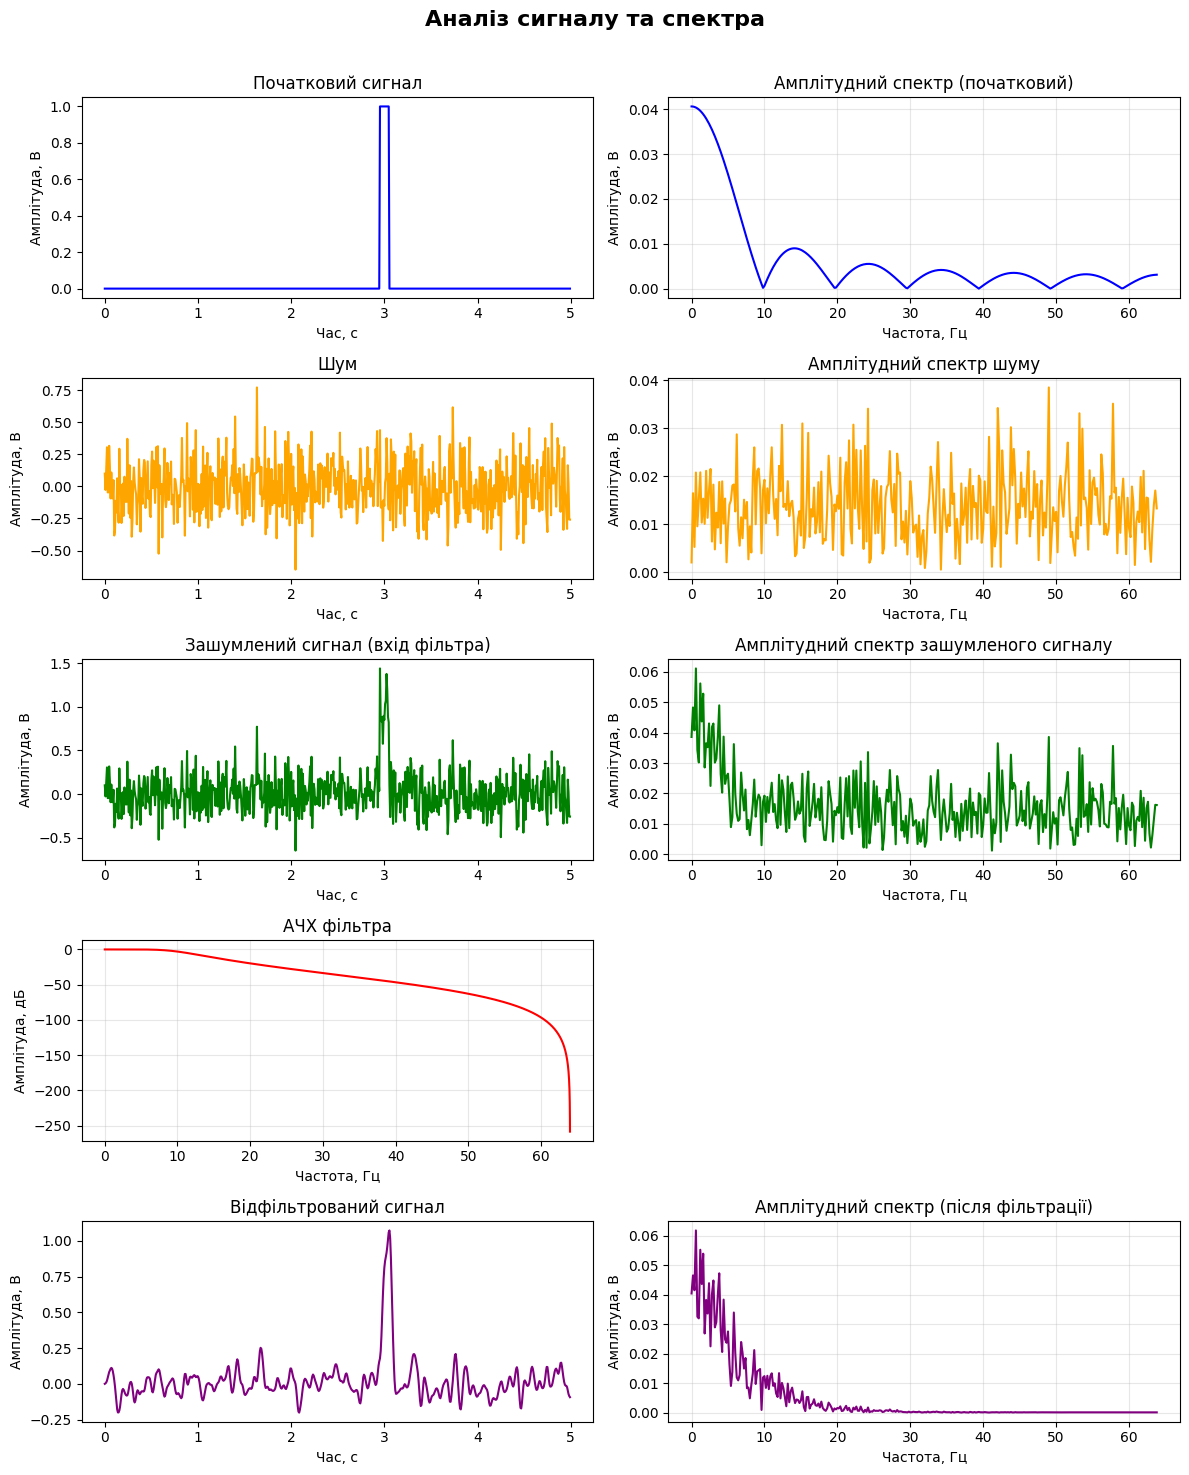

In [12]:
plot_signal_pipeline(t, clean, noise, noisy, filtered, h, w, fs)

На вхід задається низькочастотний сигнал, з широкосмуговим шумом.  
Для таких задач - слід використати ФНЧ. Такі фільтри зберігають незмінною величину спектральних складових вхідного сигналу на нижніх частотах -- вони пропускають низькочастотні сигнали та не пропускають високочастотні.  
Зрештою, теоретичні результати підтверджуються експериментальними -- на графіку можна побачит, що сигнал після фільтру став більш "чистим", залишивши низькі чистоти (зашумлений початковий фрагмент) та зменшений шум. Також, SNR покращився після застовування фільтру.

## Завдання 2

In [13]:
T = 1
fs = 128
t = np.linspace(0, T, int(T*fs), endpoint=False)



In [14]:
f0 = 10.0
clean = 1.0 * np.sin(2 * np.pi * f0 * t)

In [15]:
noise = np.random.normal(loc=0.0, scale=1.0, size=t.shape)
noisy = clean + noise

In [16]:
nyq = fs / 2.0
rp = 3

In [17]:
wp_hz_lp = 15.0
ws_hz_lp = 20.0
wp_lp = wp_hz_lp / nyq
ws_lp = ws_hz_lp / nyq

chosen_rs_lp = None
chosen_N_lp = None
chosen_Wn_lp = None
for rs_candidate in np.arange(1.0, 101.0, 0.5):
    try:
        N_c, Wn_c = cheb1ord(wp_lp, ws_lp, rp, rs_candidate)
    except Exception:
        continue
    if 3 <= N_c <= 7:
        chosen_rs_lp = rs_candidate
        chosen_N_lp = int(N_c)
        chosen_Wn_lp = Wn_c
        break

b_lp, a_lp = cheby1(chosen_N_lp, rp, chosen_Wn_lp, btype='low', output='ba')
filtered_lp = lfilter(b_lp, a_lp, noisy)
w_lp, h_lp = freqz(b_lp, a_lp, worN=8000, fs=fs)

snr_in_lp = compute_snr(clean, noisy)
snr_out_lp = compute_snr(clean, filtered_lp)
print(f"Chebyshev-I LP: order={chosen_N_lp}, rs={chosen_rs_lp} dB; SNR_in={snr_in_lp:.2f} dB, SNR_out={snr_out_lp:.2f} dB")

Chebyshev-I LP: order=3, rs=10.0 dB; SNR_in=-3.30 dB, SNR_out=-2.13 dB


In [18]:
wp_hz_bs = [45.0, 55.0]
ws_hz_bs = [49.0, 51.0]
wp_bs = [f / nyq for f in wp_hz_bs]
ws_bs = [f / nyq for f in ws_hz_bs]

chosen_rs_bs = None
chosen_N_bs = None
chosen_Wn_bs = None
for rs_candidate in np.arange(1.0, 101.0, 0.5):
    try:
        N_c, Wn_c = cheb1ord(wp_bs, ws_bs, rp, rs_candidate)
    except Exception:
        continue
    if LOWER_BOUND <= N_c <= UPPER_BOUND:
        chosen_rs_bs = rs_candidate
        chosen_N_bs = int(N_c)
        chosen_Wn_bs = Wn_c
        break

b_bs, a_bs = cheby1(chosen_N_bs, rp, chosen_Wn_bs, btype='bandstop', output='ba')
filtered_bs = lfilter(b_bs, a_bs, noisy)
w_bs, h_bs = freqz(b_bs, a_bs, worN=8000, fs=fs)

snr_in_bs = compute_snr(clean, noisy)
snr_out_bs = compute_snr(clean, filtered_bs)
print(f"Chebyshev-I Bandstop: order={chosen_N_bs}, rs={chosen_rs_bs} dB; SNR_in={snr_in_bs:.2f} dB, SNR_out={snr_out_bs:.2f} dB")

Chebyshev-I Bandstop: order=3, rs=32.0 dB; SNR_in=-3.30 dB, SNR_out=-1.10 dB


In [19]:
wp_hz_hp = 5.0
ws_hz_hp = 2.0
wp_hp = wp_hz_hp / nyq
ws_hp = ws_hz_hp / nyq

chosen_rs_hp = None
chosen_N_hp = None
chosen_Wn_hp = None
for rs_candidate in np.arange(1.0, 101.0, 0.5):
    try:
        N_c, Wn_c = cheb1ord(wp_hp, ws_hp, rp, rs_candidate)
    except Exception:
        continue
    if LOWER_BOUND <= N_c <= UPPER_BOUND:
        chosen_rs_hp = rs_candidate
        chosen_N_hp = int(N_c)
        chosen_Wn_hp = Wn_c
        break


b_hp, a_hp = cheby1(chosen_N_hp, rp, chosen_Wn_hp, btype='high', output='ba')
filtered_hp = lfilter(b_hp, a_hp, noisy)
w_hp, h_hp = freqz(b_hp, a_hp, worN=8000, fs=fs)

snr_in_hp = compute_snr(clean, noisy)
snr_out_hp = compute_snr(clean, filtered_hp)
print(f"Chebyshev-I Highpass: order={chosen_N_hp}, rs={chosen_rs_hp} dB; SNR_in={snr_in_hp:.2f} dB, SNR_out={snr_out_hp:.2f} dB")

Chebyshev-I Highpass: order=3, rs=21.5 dB; SNR_in=-3.30 dB, SNR_out=-4.81 dB


На вхід задається сигнал-синусоїд з стандартним Гауссівським шумом.

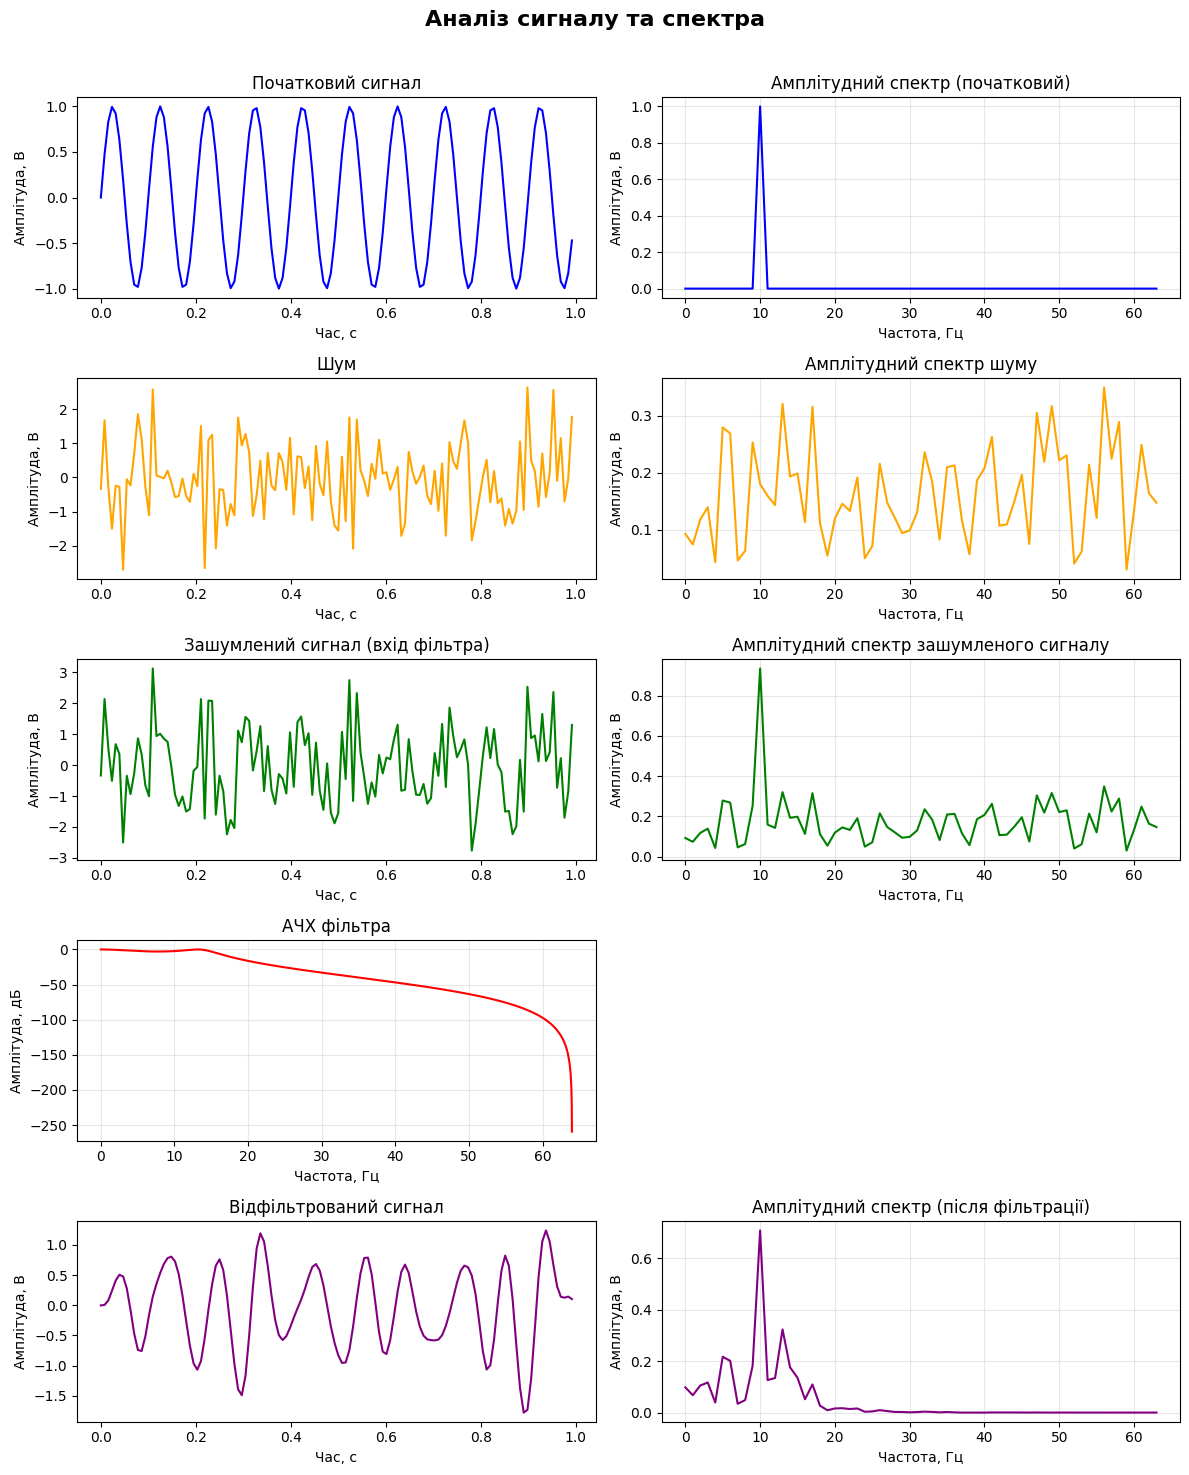

In [20]:
plot_signal_pipeline(t, clean, noise, noisy, filtered_lp, h_lp, w_lp, fs)

ФНЧ ефективно послаблює широкосмуговий шум на вищих частотах, зберігаючи амплітуду синусоїдальної складової на 10 Гц.  

Через шуми помітно зміну в амплітуді, але загалом спостерігається є підвищення SNR після фільтрації.

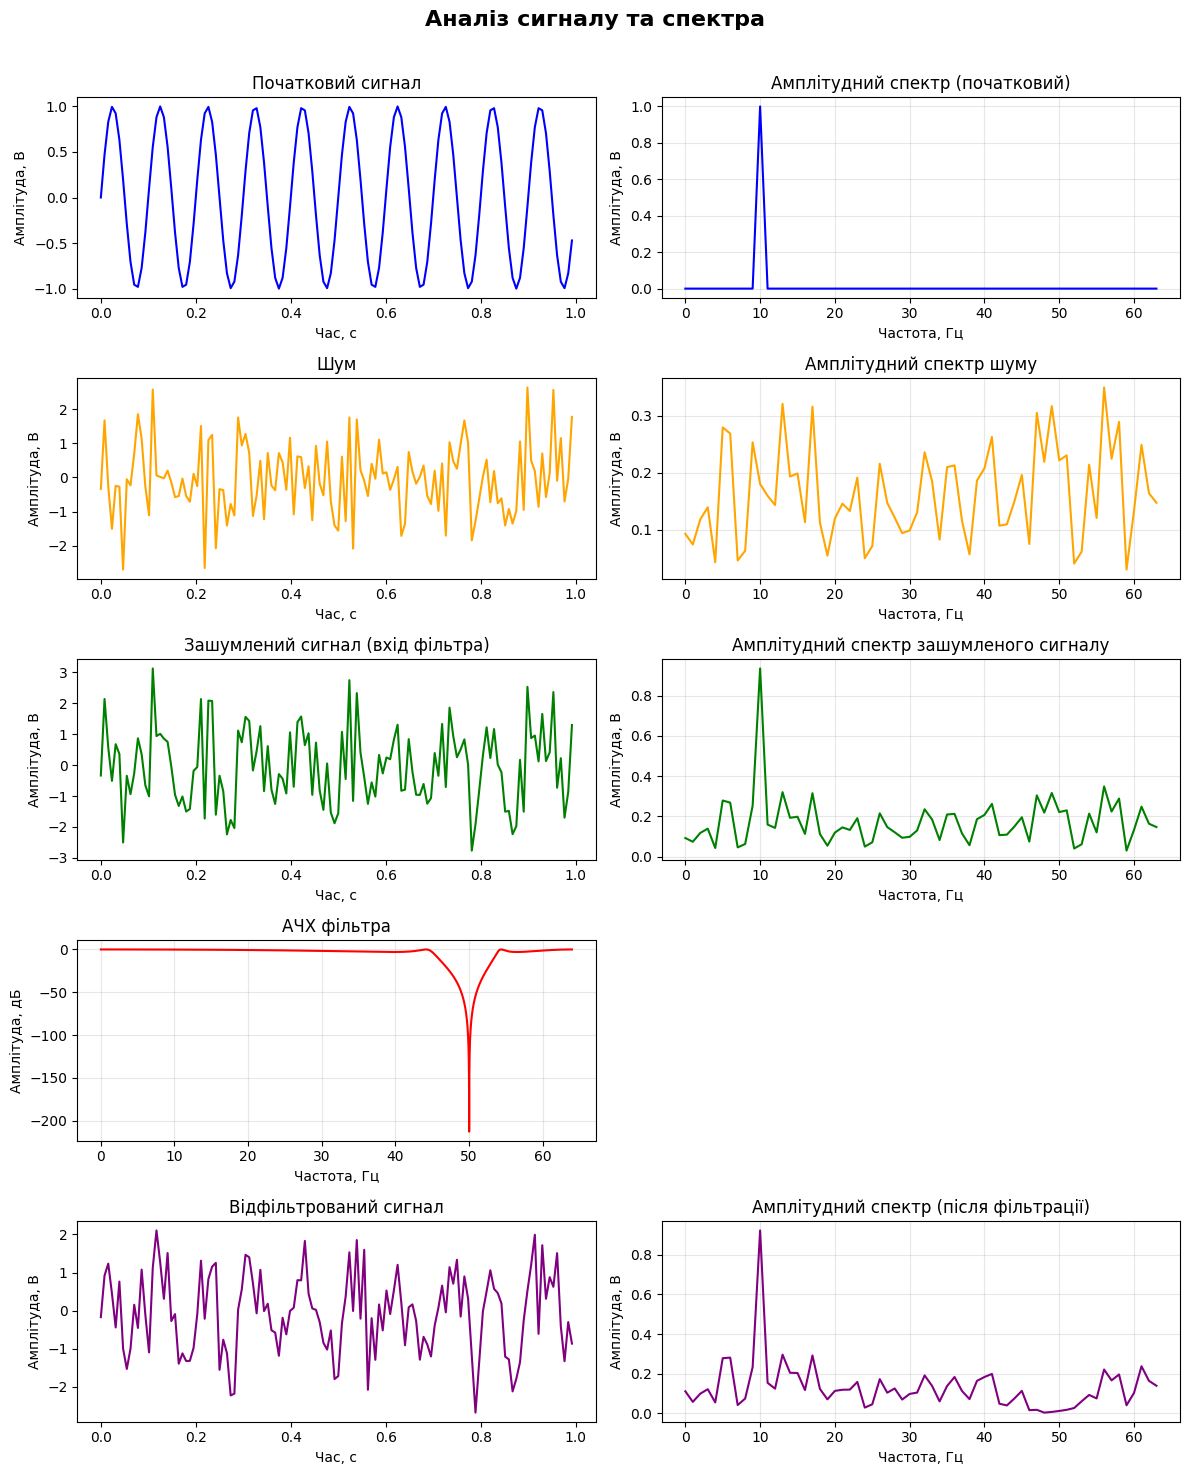

In [21]:
plot_signal_pipeline(t, clean, noise, noisy, filtered_bs, h_bs, w_bs, fs)

ЗФ налаштований на вузьку зону (навколо 45–55 Гц), практично не впливає на 10 Гц сигнал і тому не видаляє широкий шум.  

Його застосування корисне, якщо у вхідному сигналі є мережевий шум. Якщо шум широкосмуговий, покращення SNR майже не буде, що і підтверджується експериментально. 

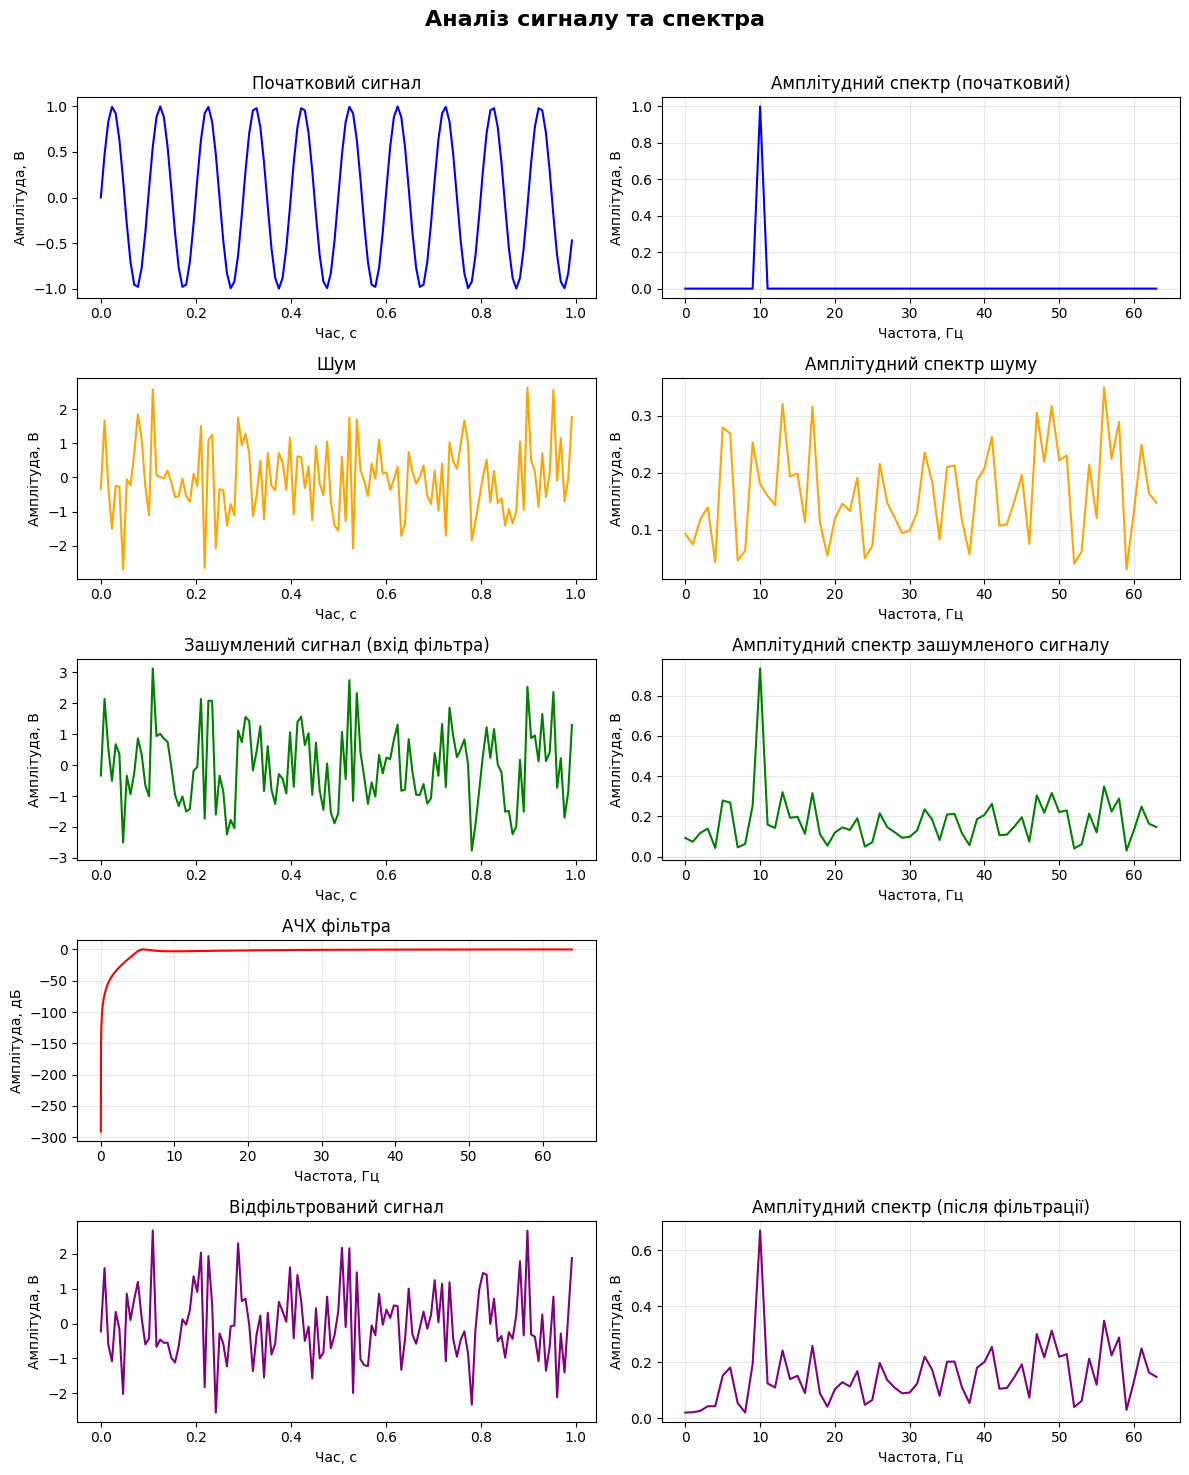

In [22]:
plot_signal_pipeline(t, clean, noise, noisy, filtered_hp, h_hp, w_hp, fs)

ФВЧ відсікає низькочастотні складові  і пропускає компоненти вище ~5 Гц, тому синусоїда на 10 Гц зберігається.  

Проте, амплітуда і фаза трохи спотворилися.  

Оскільки шум має сильну низькочастотну частину, ФВЧ підвищить SNR.

Для цього випадку ФНЧ є найкращим вибором. Він зберігає корисну низькочастотну складову та зменшує високочастотний шум.  

ЗФ ефективний лише для вузькочастотних перешкод, якого у цьому випадку немає.  

ФВЧ корисний для усунення низькочастотних завад, але може мати невеликі спотворення.

## Завдання 3

In [23]:
T = 10
fs = 128
t = np.linspace(0, T, int(T*fs), endpoint=False)

In [24]:
amp = 10e-3
signal = amp * np.random.normal(loc=0.0, scale=1.0, size=t.shape)

In [25]:
interf_freq = 50.0
interf_amp = 1.0
interf = interf_amp * np.sin(2 * np.pi * interf_freq * t)
noisy = signal + interf

In [26]:
nyq = fs / 2.0
gpass = 3
min_gstop = None
chosen_N_bs = None
chosen_Wn_bs = None

wp_hz_bs = [45.0, 55.0]
ws_hz_bs = [49.0, 51.0]
wp_bs = [f / nyq for f in wp_hz_bs]
ws_bs = [f / nyq for f in ws_hz_bs]

for gstop_candidate in np.arange(1.0, 101.0, 0.5):
    try:
        N_c, Wn_c = buttord(wp_bs, ws_bs, gpass, gstop_candidate)
    except Exception:
        continue
    if LOWER_BOUND <= N_c <= UPPER_BOUND:
        min_gstop = gstop_candidate
        chosen_N_bs = int(N_c)
        chosen_Wn_bs = Wn_c
        break

C:\Users\basys\AppData\Local\Temp\ipykernel_19056\3274935472.py:14: RuntimeWarning: Order is zero...check input parameters.
  N_c, Wn_c = buttord(wp_bs, ws_bs, gpass, gstop_candidate)


In [27]:
b_bs, a_bs = butter(chosen_N_bs, chosen_Wn_bs, btype='bandstop', output='ba')
w_bs, h_bs = freqz(b_bs, a_bs, worN=8000, fs=fs)
filtered_bs = lfilter(b_bs, a_bs, noisy)

In [28]:
snr_in_bs = compute_snr(signal, noisy)
snr_out_bs = compute_snr(signal, filtered_bs)
print(f"Butterworth Bandstop (notch): order={chosen_N_bs}, gstop={min_gstop} dB; SNR_in={snr_in_bs:.2f} dB, SNR_out={snr_out_bs:.2f} dB")

Butterworth Bandstop (notch): order=3, gstop=26.5 dB; SNR_in=-37.06 dB, SNR_out=-8.18 dB


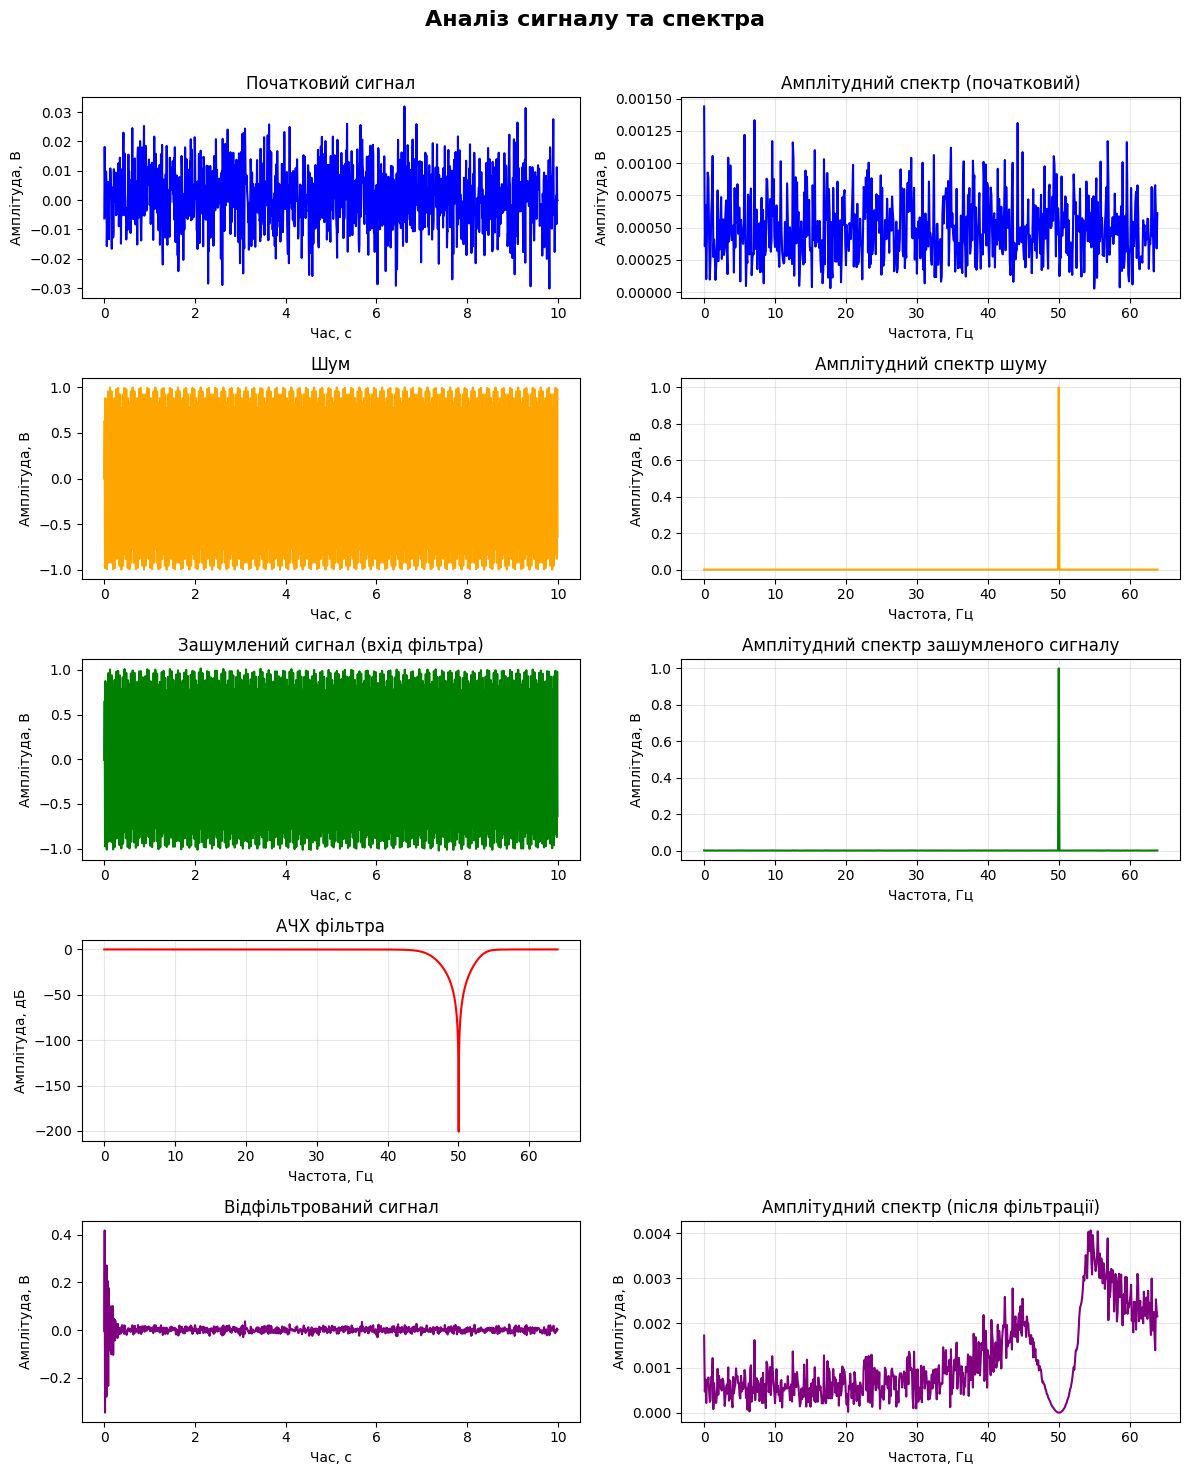

In [29]:
plot_signal_pipeline(t, signal, interf, noisy, filtered_bs, h_bs, w_bs, fs)

Можна побачити, що проєктований ЗВ фільтр помітну послаблює мережеву перешкоду. У амплітудному спектрі видно глибоку впадину навколо 50 Гц, а у часовій області основна перешкода значно зменшена.  

Корисний (початковий) випадковий сигнал дуже мало пошкоджено, проте видно артефакти на початку -- шум погано прибрався. Це ймовірно через те, що фільтр має "пам'ять", та не може відразу прибрати все. Кращий результат може бути отриманий, якщо використати `filtfilt` замість `lfilter`.  

Можна побачити значне підвищення SNR після фільтрації.  


Фільтр ЗВ Butterworth ефективно видаляє мережеву 50 Гц перешкоду і значно підвищує відношення сигнал/шум при збереженні корисного сигналу -- це робить його придатним рішенням для видалення вузькополосних мережевих наводок у цьому завданні.

## Завдання 4

In [30]:
cool_song_8k, fs8k = sf.read('../lab01/output/cool_song_8khz.wav')
cool_song_44k, fs44k = sf.read('../lab01/output/cool_song_44khz.wav')

In [31]:
print(f"8 kHz sample rate: {fs8k}, shape: {cool_song_8k.shape}")
print(f"44 kHz sample rate: {fs44k}, shape: {cool_song_44k.shape}")

8 kHz sample rate: 8000, shape: (40000, 2)
44 kHz sample rate: 44100, shape: (220500, 2)


In [32]:
def butter_filter(data, fs, band, order=5):
    nyq = fs / 2
    if band[0] == 0:
        btype = 'low'
        Wn = band[1] / nyq
    elif band[1] >= nyq:
        btype = 'high'
        Wn = band[0] / nyq
    else:
        btype = 'band'
        Wn = [band[0] / nyq, band[1] / nyq]
    b, a = butter(order, Wn, btype=btype)
    w, h = freqz(b, a, worN=1024, fs=fs)
    filtered = lfilter(b, a, data, axis=0)
    return filtered, w, h

In [33]:
bands = [(0, 450), (450, 1000), (1000, 4000)]

In [34]:
try:
    os.mkdir('output')
except FileExistsError:
    pass

Processing band: (0, 450) Hz at 8000 Hz sample rate
(0, 450): SNR before = inf dB, after = -0.75 dB


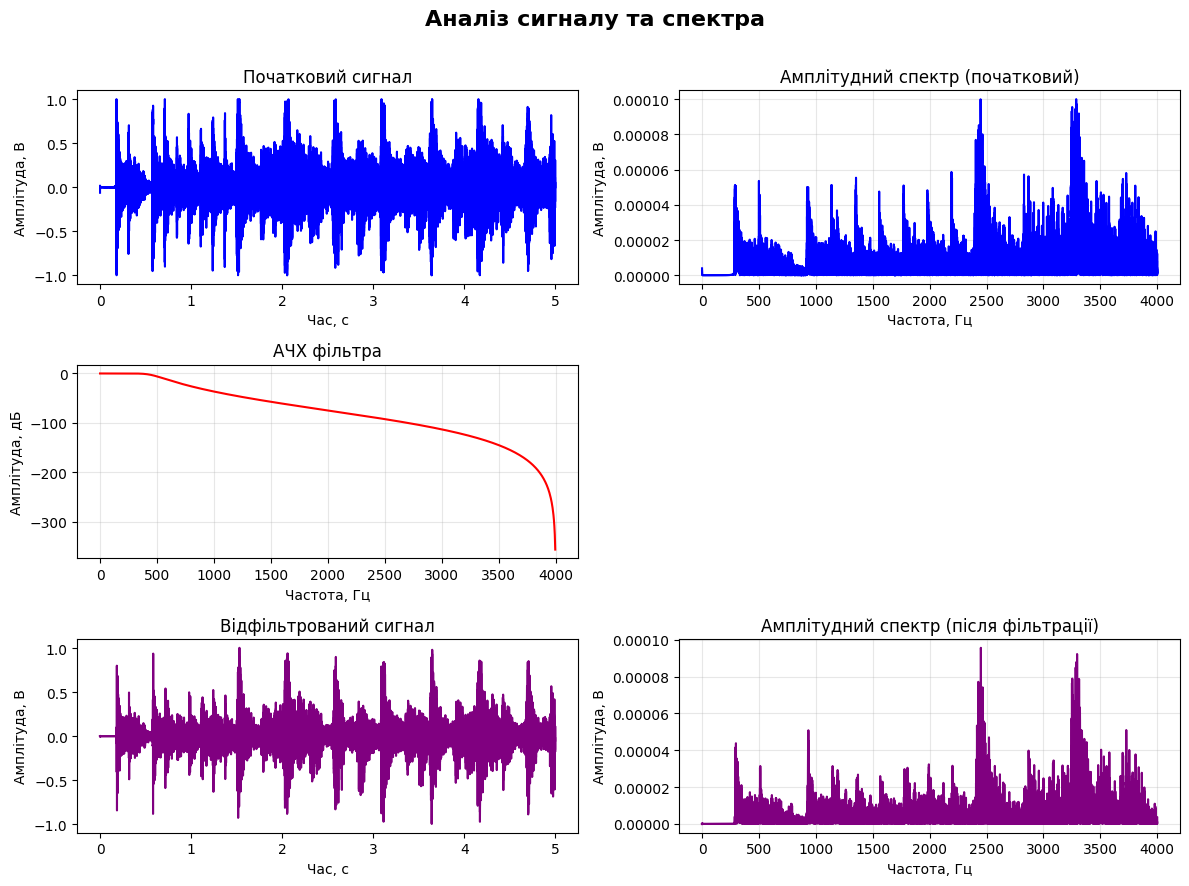

Saved: output/filtered_8000_0_450Hz.wav
Processing band: (450, 1000) Hz at 8000 Hz sample rate
(450, 1000): SNR before = inf dB, after = -0.30 dB


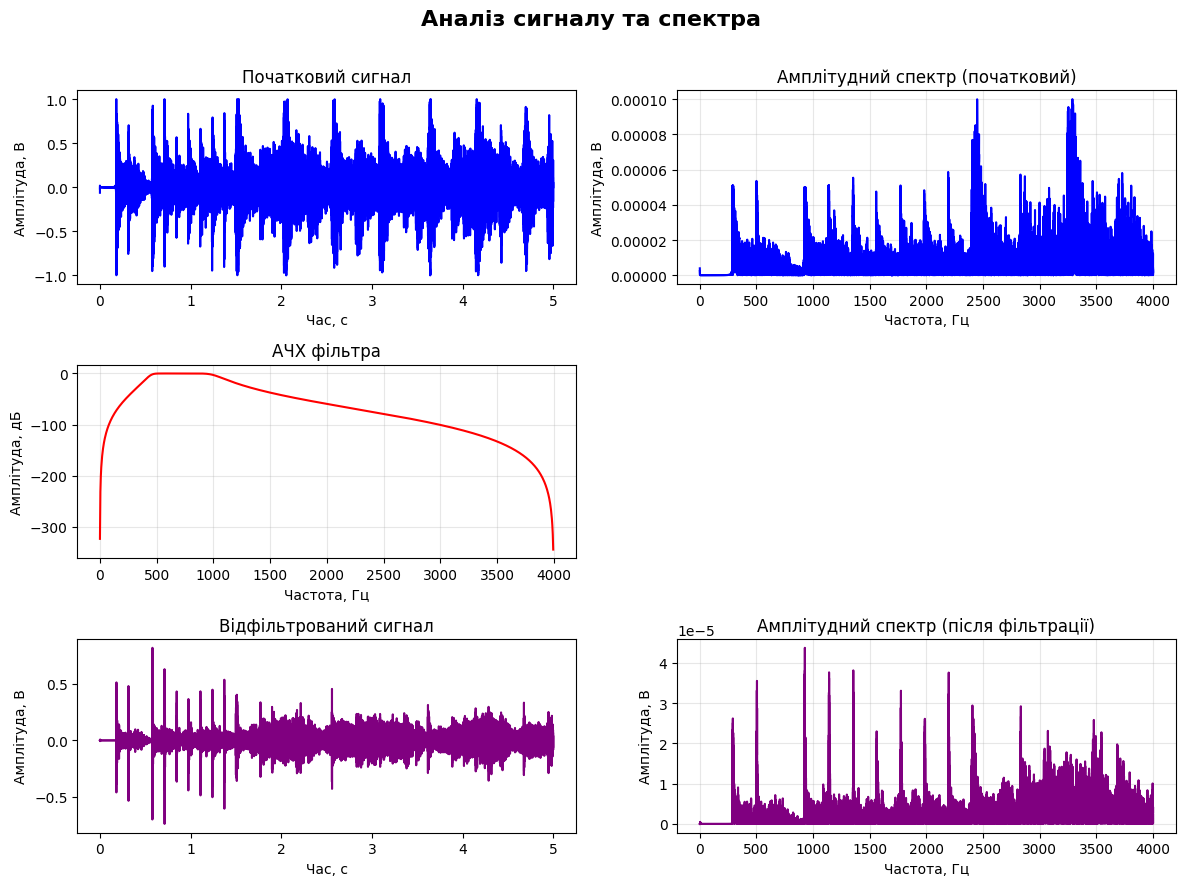

Saved: output/filtered_8000_450_1000Hz.wav
Processing band: (1000, 4000) Hz at 8000 Hz sample rate
(1000, 4000): SNR before = inf dB, after = -0.13 dB


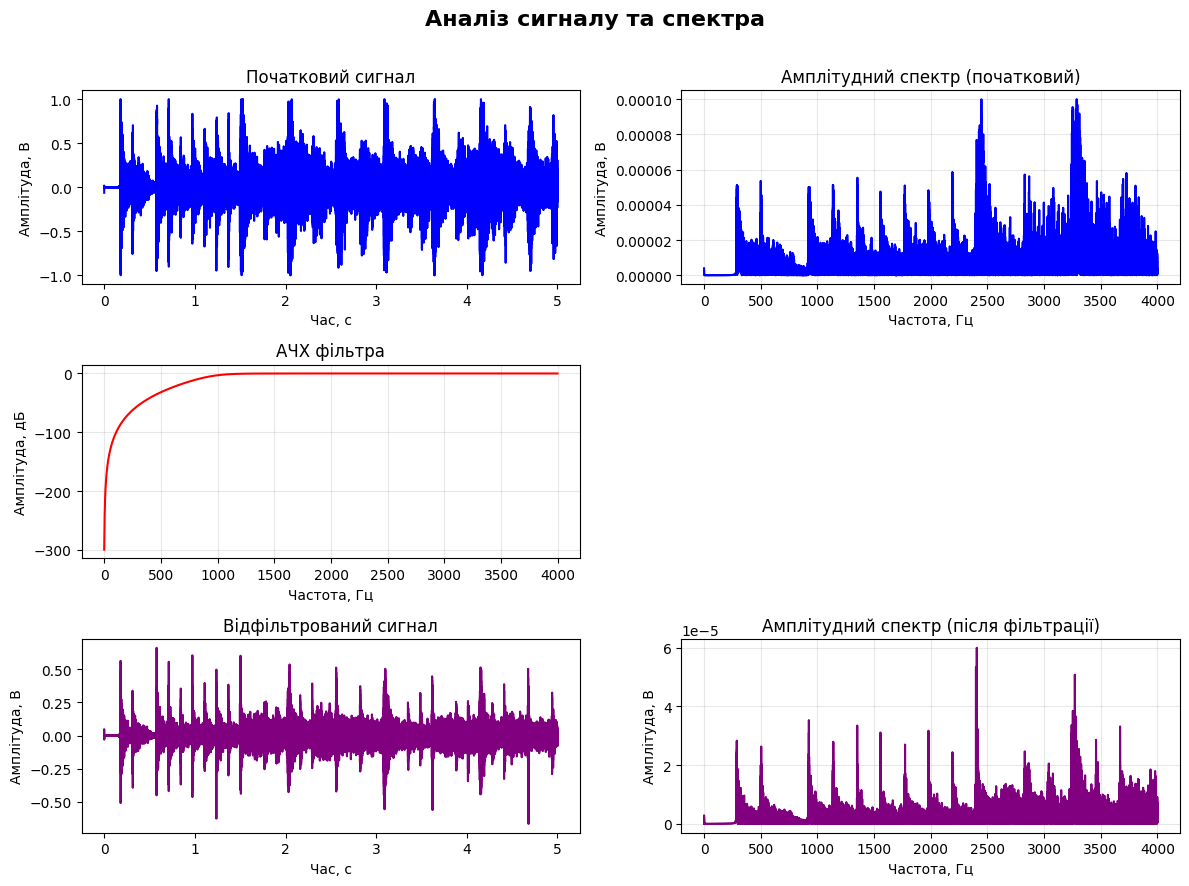

Saved: output/filtered_8000_1000_4000Hz.wav
Processing band: (0, 450) Hz at 44100 Hz sample rate
(0, 450): SNR before = inf dB, after = -0.73 dB


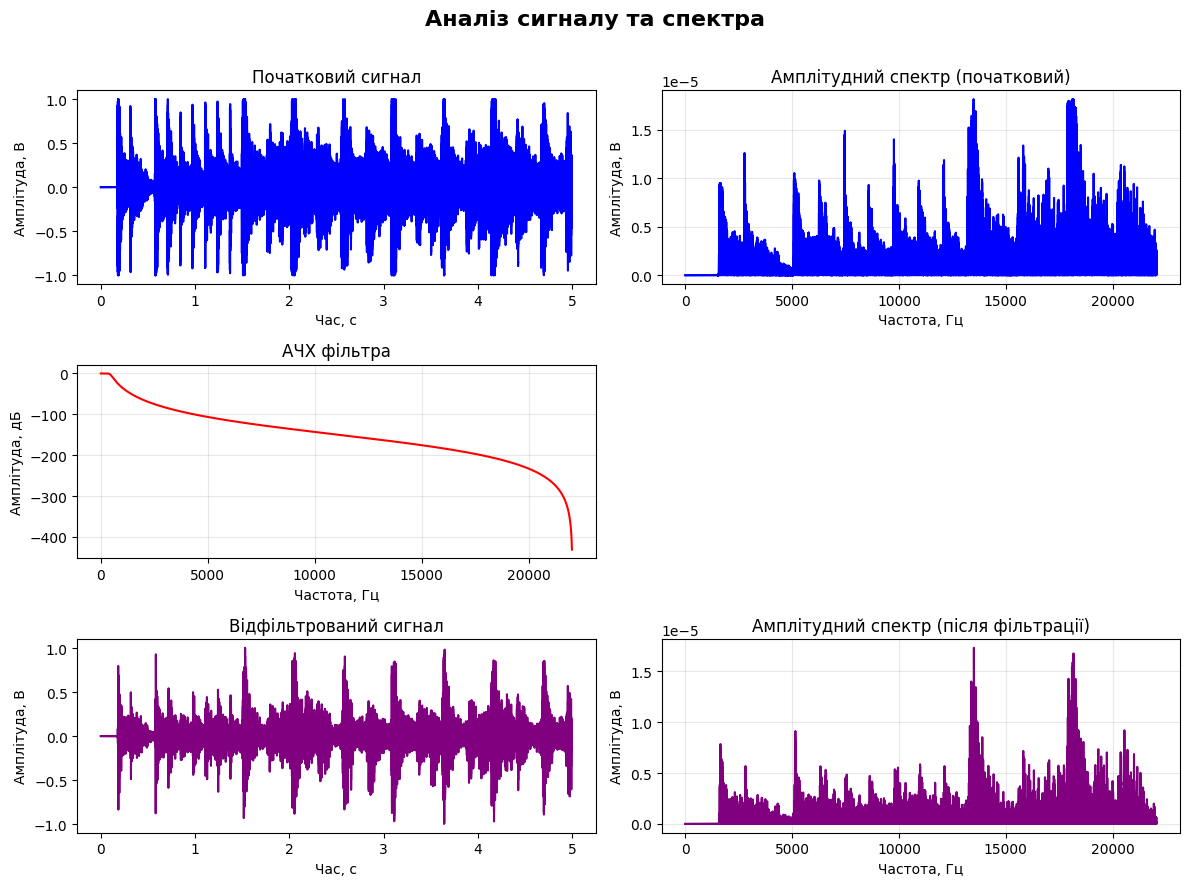

Saved: output/filtered_44100_0_450Hz.wav
Processing band: (450, 1000) Hz at 44100 Hz sample rate
(450, 1000): SNR before = inf dB, after = -0.28 dB


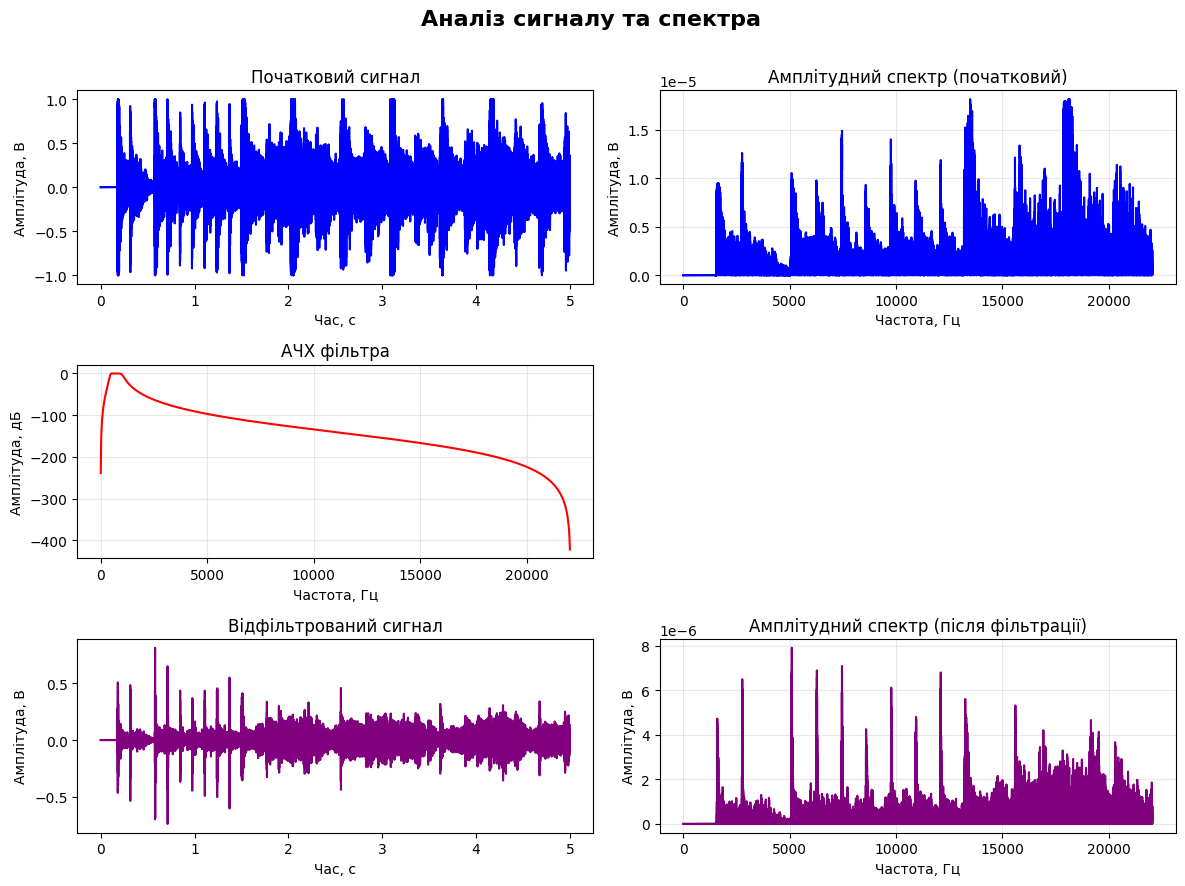

Saved: output/filtered_44100_450_1000Hz.wav
Processing band: (1000, 4000) Hz at 44100 Hz sample rate
(1000, 4000): SNR before = inf dB, after = -0.31 dB


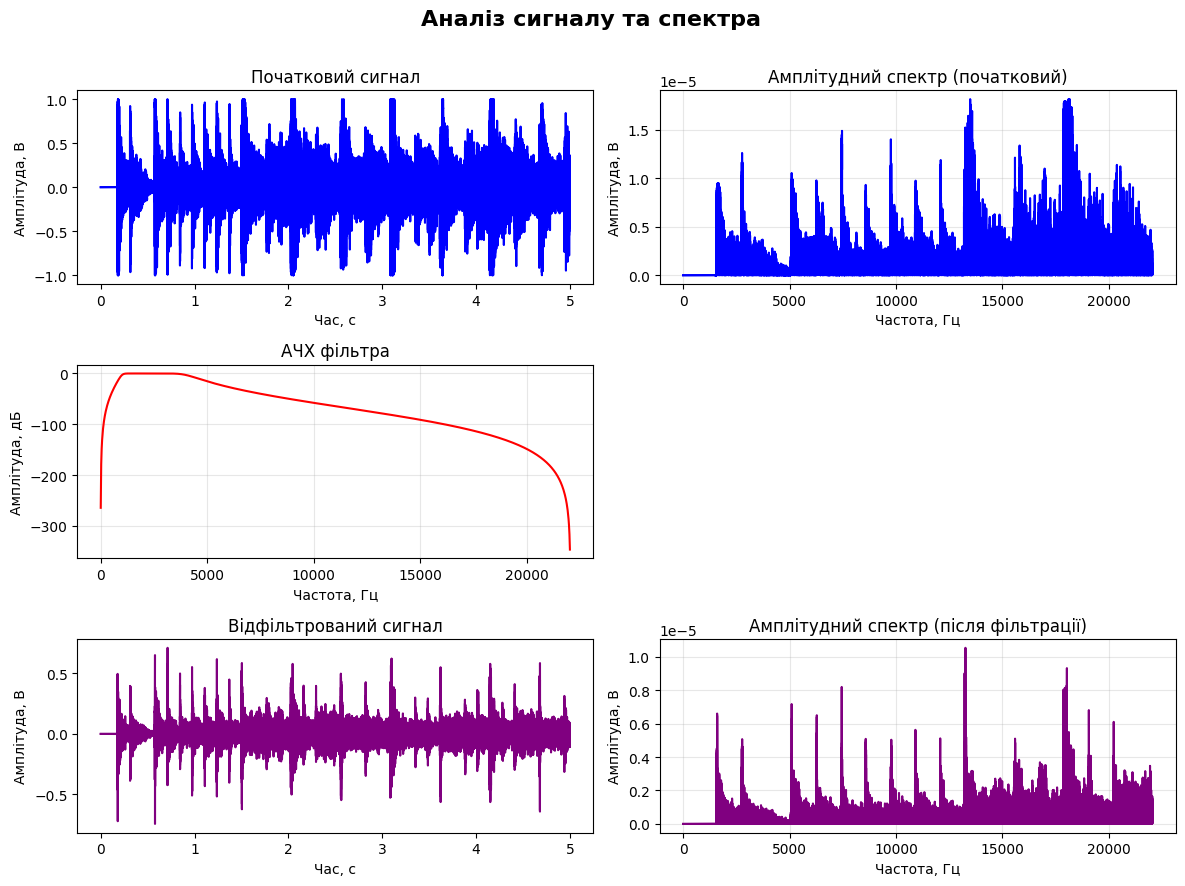

Saved: output/filtered_44100_1000_4000Hz.wav


In [35]:
for signal, fs in [(cool_song_8k, fs8k), (cool_song_44k, fs44k)]:
    t = np.arange(len(signal)) / fs
    for band_range in bands:
        print(f"Processing band: {band_range} Hz at {fs} Hz sample rate")
        filtered, w, h = butter_filter(signal, fs, band_range, order=5)
        snr_in = compute_snr(signal, signal)
        snr_out = compute_snr(signal, filtered)

        snr_in_str = f"{snr_in:.2f}"
        print(f"{band_range}: SNR before = {snr_in_str} dB, after = {snr_out:.2f} dB")

        plot_signal_pipeline(
            t, signal, np.zeros_like(signal), signal, filtered, h, w, fs, hide_noise=True
        )

        out_name = f"output/filtered_{int(fs)}_{band_range[0]}_{band_range[1]}Hz.wav"
        sf.write(out_name, filtered, fs)
        print(f"Saved: {out_name}")


Низькочастотний сигнал (0–450 Гц) передає басову складову -- удари барабанів, бас-гітару. Відсутні високі частоти, тому звук сприймається приглушеним.  

Середньочастотний сигнал (450–1000 Гц) звучить приглушено. Вузький спектр без басу й без "повітря". Смуга охоплює середні ноти. 

Високочастотний сигнал (1000–4000 Гц) містить високі гармоніки, що формують тембр і "яскравість", чіткість, але без основного тембру.

На графіках спектрів чітко видно обрізання поза вибраним діапазоном -- що підтверджує правильну роботу фільтрів.

Фільтри Баттерворта забезпечують плавний перехід у зоні зрізу, без помітних спотворень у смузі пропускання.

Слід взяти повний файл з домашки 1, аби прослухати частинки з вокалом.

In [36]:
cool_song_full, fs = sf.read('../lab01/data/music/cool_song.mp3')

In [37]:
t_full = np.arange(len(cool_song_full)) / fs
for band_range in bands:
    filtered, w, h = butter_filter(cool_song_full, fs, band_range, order=5)
    out_name = f"output/full_song{band_range}.wav"
    sf.write(out_name, filtered, fs)
    print(f"Saved: {out_name}")

Saved: output/full_song(0, 450).wav
Saved: output/full_song(450, 1000).wav
Saved: output/full_song(1000, 4000).wav


Голос найменш чітко та заглушено чути на низькочастотному сигналі.   

На середньочастотноум - ситуація краще, проте голос усе ще приглушений.  

На високочастотному - голос чутно трохи краще, більш розбірно.